# RSI model-01
https://chatgpt.com/c/67f9fbc1-777c-800a-a56a-aadd83458b40

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from ta.momentum import RSIIndicator

In [16]:
# Load full training data
df = pd.read_csv("../datasets/XAGUSD-H1-rates.csv", sep=r'\s+', engine='python')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('Datetime')
df.reset_index(drop=True, inplace=True)

# Use RSIIndicator from ta
rsi = RSIIndicator(close=df['Close'], window=14)
df['RSI'] = rsi.rsi()

# Drop NaN rows from RSI calculation
df.dropna(inplace=True)

In [22]:
# Labeling reversal (RSI 30/70)
def label_reversal_targets(data, future_window=5):
    labels = []
    for i in range(len(data) - future_window):
        rsi_now = data.iloc[i]['RSI']
        rsi_future = data.iloc[i+1:i+future_window+1]['RSI']

        if rsi_now < 30 and any(r > 35 for r in rsi_future):
            labels.append(1)  # Bullish reversal
        elif rsi_now > 70 and any(r < 65 for r in rsi_future):
            labels.append(1)  # Bearish reversal
        else:
            labels.append(0)
    return np.array(labels)

labels = label_reversal_targets(df)


In [18]:
# Prepare input windows
SEQ_LEN = 30
features = ['Open', 'High', 'Low', 'Close', 'RSI']

X = []
for i in range(len(df) - SEQ_LEN - 5):  # 5 for future reversal window
    window = df.iloc[i:i+SEQ_LEN][features].values
    X.append(window)

X = np.array(X)
y = labels[:len(X)]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (55035, 30, 5)
y shape: (55035,)


In [19]:
# Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(features))),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


/home/saeed/repositories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9530 - loss: 0.1945 - val_accuracy: 0.9486 - val_loss: 0.2032
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9539 - loss: 0.1862 - val_accuracy: 0.9486 - val_loss: 0.1748
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9527 - loss: 0.1677 - val_accuracy: 0.9487 - val_loss: 0.1798
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9568 - loss: 0.1293 - val_accuracy: 0.9439 - val_loss: 0.1483
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9575 - loss: 0.1119 - val_accuracy: 0.9548 - val_loss: 0.1083
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9594 - loss: 0.0999 - val_accuracy: 0.9500 - val_loss: 0.1140
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9631 - loss: 0.0891 - val_accuracy: 0.9597 - val_loss: 0.0934
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9637 - loss: 0.0852 - 

In [28]:
# Predict on rows1-30.csv
df_input = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r'\s+', engine='python')
df_input.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']


# Use RSIIndicator
rsi_input = RSIIndicator(close=df_input['Close'], window=14)
df_input['RSI'] = rsi_input.rsi()

df_input.dropna(inplace=True)  # Drop NaNs from RSI

# Build input sample
sample = df_input[['Open', 'High', 'Low', 'Close', 'RSI']].values[-30:]
sample = np.expand_dims(sample, axis=0)  # Shape: (1, 30, 5)


# Predict
prediction = model.predict(sample)[0][0]
print("Reversal probability in next 5 candles:", round(prediction * 100, 2), "%")

if prediction > 0.5:
    print("⚠️ Likely reversal ahead!")
else:
    print("✅ No reversal detected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Reversal probability in next 5 candles: 67.38 %
⚠️ Likely reversal ahead!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


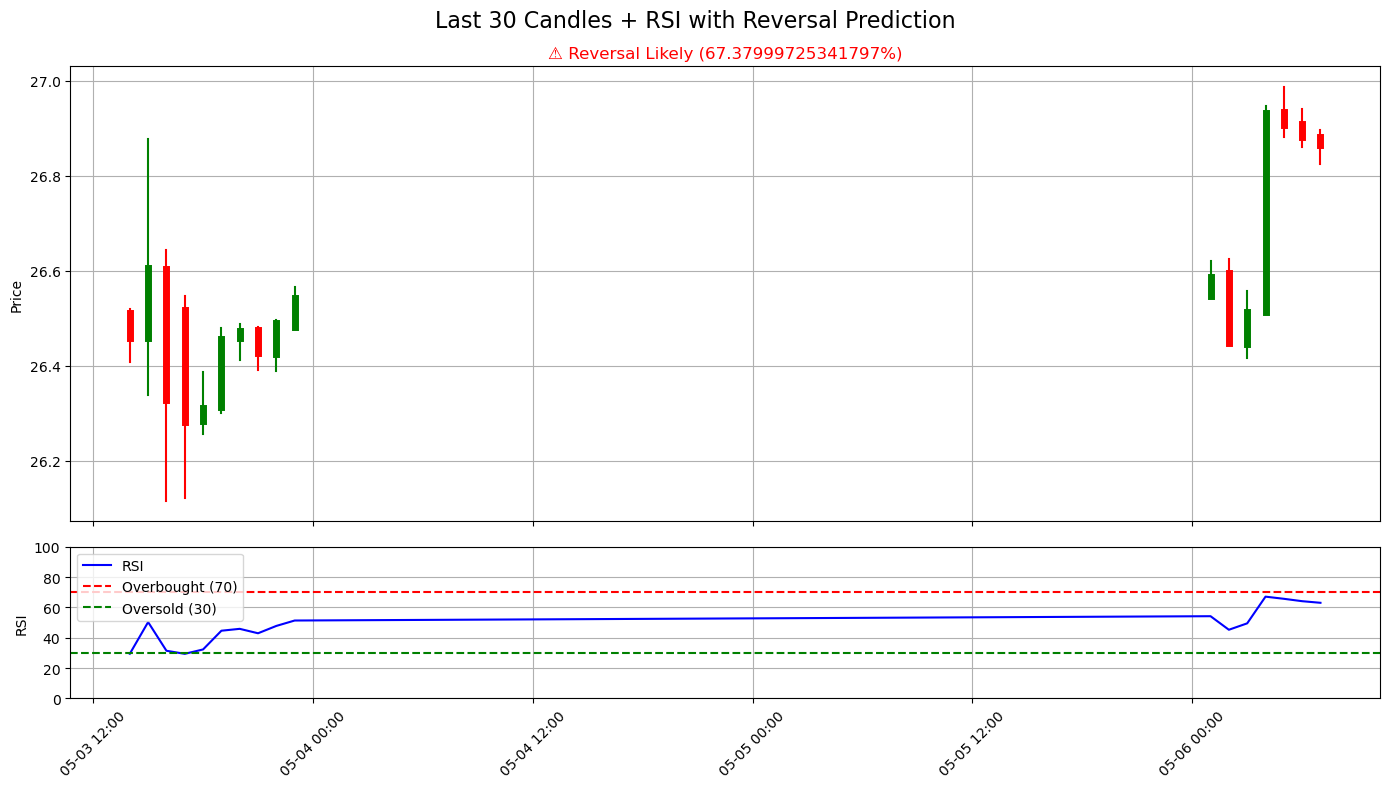

In [29]:
import matplotlib.dates as mdates

# Load 30 candles
df_input = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r'\s+', engine='python')
df_input.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']
df_input['Datetime'] = pd.to_datetime(df_input['Date'] + ' ' + df_input['Time'])

# Compute RSI
rsi_input = RSIIndicator(close=df_input['Close'], window=14)
df_input['RSI'] = rsi_input.rsi()

# Drop NaNs
df_input = df_input.dropna().reset_index(drop=True)

# Prepare model input (last 30 candles after RSI drop)
sample = df_input[['Open', 'High', 'Low', 'Close', 'RSI']].values[-30:]
sample_input = np.expand_dims(sample, axis=0)

# Predict
prediction = model.predict(sample_input)[0][0]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle("Last 30 Candles + RSI with Reversal Prediction", fontsize=16)

# Plot candlesticks
dates = df_input['Datetime']
for i in range(len(df_input)):
    color = 'green' if df_input['Close'][i] >= df_input['Open'][i] else 'red'
    ax1.plot([dates[i], dates[i]], [df_input['Low'][i], df_input['High'][i]], color=color)
    ax1.plot([dates[i], dates[i]], [df_input['Open'][i], df_input['Close'][i]], color=color, linewidth=5)

ax1.set_ylabel("Price")
ax1.grid(True)

# Show reversal prediction
if prediction > 0.5:
    ax1.set_title(f"⚠️ Reversal Likely ({round(prediction * 100, 2)}%)", color='red')
else:
    ax1.set_title(f"✅ No Reversal Detected ({round((1 - prediction) * 100, 2)}%)", color='green')

# Plot RSI
ax2.plot(dates, df_input['RSI'], label="RSI", color='blue')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70)")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_ylabel("RSI")
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
